In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean

In [4]:
dl = DataLib("SignalData")
bond_return_index = dl.pull('BondRetIdx/LocalFX')
long_rates = dl.pull('LongRates')
country_codes = bond_return_index.columns

In [5]:
rf_rates = dl.pull('RFrates').divide(100)
daily_rf_rates = (rf_rates + 1).pow(1/261)-1
daily_rf_rates = daily_rf_rates.resample('B').ffill()

monthly_rf_rates = (rf_rates + 1).pow(1/12)-1

rf_rate_matrix = pd.DataFrame(0, index=bond_return_index.index, 
                              columns=bond_return_index.columns)
rf_rate_matrix_monthly = pd.DataFrame(0, index=monthly_rf_rates.index, 
                              columns=bond_return_index.columns)
for country in country_codes:
    rf_rate_matrix[country] = daily_rf_rates
    rf_rate_matrix_monthly[country] = monthly_rf_rates

# Helper Functions

**Profit and Loss Curve Functions**

In [6]:
# Plot the PNL curve with all countries + average returns
def pnl_curve(signals):
    daily_signals = signals.resample("B").ffill()
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix
    lagged_returns = bond_daily_returns.shift(-1)

    sig_returns = (lagged_returns * daily_signals)
    cum_sig_returns = (1+sig_returns).cumprod()
    
    cum_sig_returns.plot(alpha=0.5, cmap='rainbow')
    cum_sig_returns.mean(axis=1).plot(color='black', label='AVG')
    plt.legend()
    plt.title('Total Cumulative Returns')
    plt.ylabel('Cumulative Returns')
    plt.show()


# Plot an average PNL curve compared to a long-only strategy + long rates
def pnl_curve_with_long(signals):
    daily_signals = signals.resample("B").ffill()
    long_signals = pd.DataFrame(1, index=daily_signals.index, 
                               columns=daily_signals.columns)
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix
    lagged_returns = bond_daily_returns.shift(-1)

    sig_returns = (lagged_returns * daily_signals)
    long_returns = (lagged_returns * long_signals)
    scaler = sig_returns.std()/long_returns.std()
    
    cum_sig_returns = (1+sig_returns).cumprod()
    cum_long_returns = (1+long_returns*scaler).cumprod()
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(cum_sig_returns.mean(axis=1).to_timestamp(), color='blue', 
                 label = 'Signal Returns')
    ax1.plot(cum_long_returns.mean(axis=1).to_timestamp(), color='magenta',
             label = 'Long-Only Returns')
    ax1.set_ylabel('Volatility-Adjusted Avg Cumulative Returns')
    ax1.legend(loc=2)
    ax2.plot(long_rates.mean(axis=1).to_timestamp(), alpha=.5,color='green', 
             label = 'Long Rates')
    ax2.set_ylabel('Avg Long Rates (%)')
    ax2.legend(loc='best')
    plt.title('Return Streams vs. Long Rates')
    plt.show()
    

**Sharpe Ratio Function**

In [7]:
# Calculate the Sharpe ratio for all countries

def sharpe_ratio(signals):
    
    daily_signals = signals.resample("B").ffill()
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix 
    lagged_returns = bond_daily_returns.shift(-1)

    returns = (lagged_returns * daily_signals) 
    
    country_SR = pd.Series(float(), index=country_codes)
    
    for country in country_codes:
        country_returns = returns[country].dropna()
        gmean_returns = gmean(1+country_returns)
        overall_return = (gmean_returns)**(261)-1
        overall_risk = country_returns.std()*np.sqrt(261)
        country_SR[country] = overall_return/overall_risk
    
    country_SR['AVERAGE'] = country_SR.mean()
    
    return(country_SR)



**Correlation with Long-Only Signals**

In [8]:
# Calculate the correlation between long-only returns and signal-generated
# returns for each country

def corr_with_long(signals):
    
    monthly_signals = signals.resample("M").ffill()
    long_signals = pd.DataFrame(1, index=monthly_signals.index,
                                columns=monthly_signals.columns)
    
    bond_monthly_returns = bond_return_index.resample('M').mean().pct_change() - rf_rate_matrix_monthly
    lagged_returns = bond_monthly_returns.shift(-1)
    
    sig_returns = lagged_returns * monthly_signals
    long_returns = lagged_returns * long_signals
    
    corr = sig_returns.corrwith(long_returns)
    corr['AVERAGE'] = corr.mean()
    return(corr)

# Curve Height Indicator

When using curve height as an indicator, it's most important to judge the different curve heights relative to other countries in a given year, since curve height is representative of international opportunity cost and will drive flows between different countries. While curve height also has an effect on domestic opportunity cost (i.e. if the curve height for bonds is low in the US, investors may instead choose to put their money in a different asset class, and the lack of demand for bonds will drive down prices and result in negative returns), I chose to focus most on the cross-country effect of curve height, since we want to maximize returns in all 10 of the given countries, rather than focus on just one. 

Secondly, curve height should be measured based on its value relative to other countries, rather than its change over time. Our best indicator will tell us where a country's curve height lies relative to other countries, rather than whether it is increasing or decreasing, because its relative value is what will drive investors to buy or sell in different countries, causing prices to either rise or fall in the future.

To calculate our indicator, first, we'll calculate curve height as an average of long and short rates.

In [9]:
long_rates = dl.pull('LongRates')
short_rates = dl.pull('ShortRates')

curve_height = (long_rates+short_rates)/2
curve_height.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.4490,-0.5615,0.5040,0.2885,-0.2510,0.9795,-0.0635,-0.4605,0.2145,0.4345
2020-05,0.5590,-0.6725,0.4275,0.3120,-0.3555,1.1510,-0.0920,-0.5950,0.1415,0.4210
2020-06,0.5865,-0.5230,0.4090,0.0900,-0.2650,0.9060,-0.0780,-0.5710,0.1155,0.4100
2020-07,0.6020,-0.5300,0.4065,0.0090,-0.3270,0.7250,-0.0450,-0.5235,0.0750,0.4230
2020-08,0.5745,-0.6105,0.3655,-0.0185,-0.4105,0.5265,-0.0540,-0.6630,0.0130,0.3390


As discussed above, relative curve heights are important when determining opportunity cost between different countries. To relativize the curve heights in each year, I calculated a simple moving global average that incorporates values from the last seven years (the average length of a typical short-term business cycle) and subtracted it from each value, to show how each country's curve height compared to the global average (in absolute terms). I then standardized within countries so that the mean and standard deviation within each country was 0 and 1, respectively.


In [10]:
# Take 7-year global average
global_avgs = curve_height.mean(axis=1)
CH_sma_7Y = global_avgs.rolling(84).mean()

# Subtract from each value
relative_CH = curve_height.sub(CH_sma_7Y,axis=0)

# Standardize in relation to a country's history over time
standardized_CH = (relative_CH-relative_CH.mean())/relative_CH.std()
standardized_CH.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,-0.821231,0.106337,0.098094,-0.337693,-0.078767,-0.108462,1.574907,1.087732,-0.236515,0.410195
2020-05,-0.745524,0.021215,0.038854,-0.312085,-0.167055,-0.002650,1.566293,0.975522,-0.298660,0.411217
2020-06,-0.718131,0.169005,0.038023,-0.448952,-0.060697,-0.131830,1.586093,1.014530,-0.307584,0.416697
2020-07,-0.696403,0.180766,0.055096,-0.489603,-0.101713,-0.223132,1.619456,1.078054,-0.329130,0.444203
2020-08,-0.700606,0.127777,0.035505,-0.494241,-0.163604,-0.324221,1.626702,0.966629,-0.373314,0.391813


Let's connect our standardized curve height value directly to bond returns. If a country's relative curve height is higher than average, I would expect investors to buy bonds in that country due to higher yields (and thus cheaper bonds). This increased demand would drive prices down, resulting in positive returns for investors in the next year. Alternatively, a country with a low relative curve height will drive investors to sell bonds in that country due to high prices, driving prices down and resulting in negative returns for investors in the next year.

To compare spot relative curve heights to returns over the coming year, I shifted quarterly bond returns forward a year and took the rolling mean over the past 4 quarters: this essentially conncets the current relative curve height to the average returns in the next year for an investor who buys the bond today. As shown in the graphs below, our reasoning is generally correct for most countries: there is a direct relationship between relative curve height and returns over the next year.

/Users/meganhoward1/.local/share/virtualenvs/Internship2020-nLH2vFU1/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


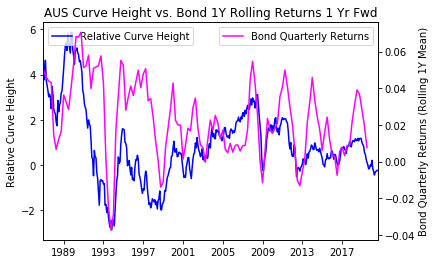

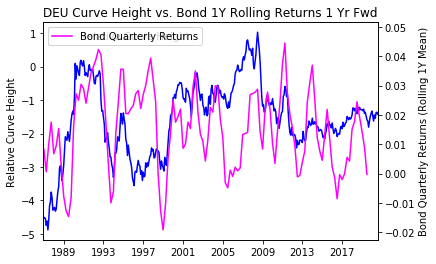

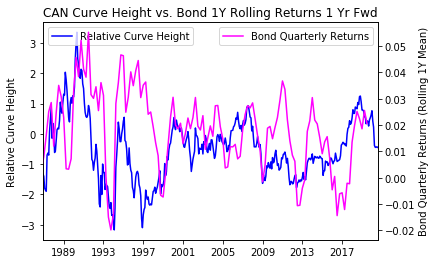

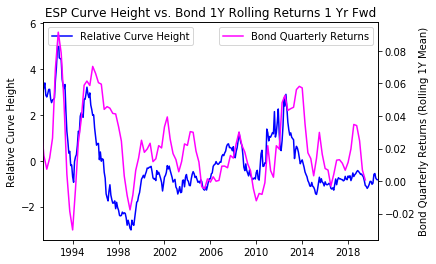

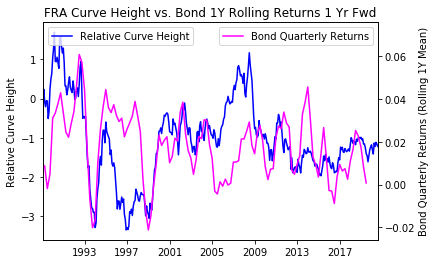

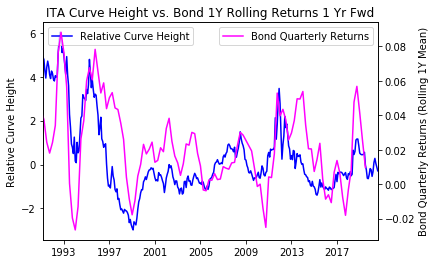

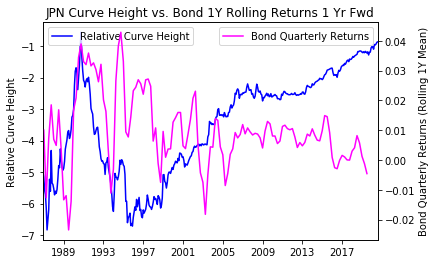

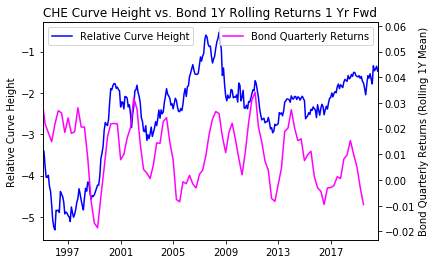

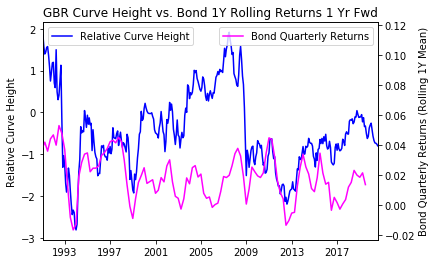

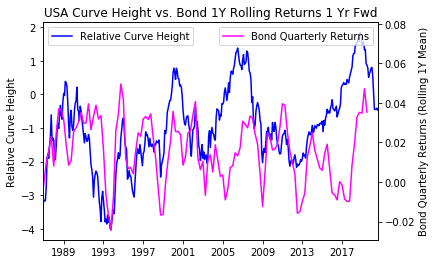

In [11]:
bond_quarterly_returns = bond_return_index.resample('Q').mean().pct_change()

for country in country_codes:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = 'Relative Curve Height'
    ax1.plot(relative_CH[country].to_timestamp(), color='blue', 
                 label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend(loc=2)
    ax2_label = 'Bond Quarterly Returns'
    ax2.plot(bond_quarterly_returns[country].shift(-4).to_timestamp()
         .rolling(4).mean(),color='magenta', label = ax2_label)
    ax2.set_ylabel('Bond Quarterly Returns (Rolling 1Y Mean)')
    ax2.legend(loc='best')
    
    
    plt.xlim(str(relative_CH[country].dropna().index.min()), 
            str(relative_CH[country].dropna().index.max()))
    plt.title(country + ' Curve Height vs. Bond 1Y Rolling Returns 1 Yr Fwd')
    plt.show()

To create the signals, I divided the standardized curve heights by 2, and clipped them from -1 to 1. This maps all values greater than 2 or less than -2 to 1 or -1, respectively, and maps other values linearly between them: for example, a value of 0.5 maps to 0.25. I did this because I wanted to only go 100% long or 100% short when curve height is drastically above or below average: 2 standard deviations above or below, which happens about 5% of the time. This gives a sharpe ratio of 0.259, on average.

In [12]:
CH_signals = standardized_CH.divide(2).clip(-1,1)
sharpe_ratio(CH_signals)

country
AUS        0.264365
DEU        0.386836
CAN        0.229559
ESP        0.336929
FRA        0.163600
ITA        0.435300
JPN        0.101062
CHE        0.019309
GBR        0.308459
USA        0.347127
AVERAGE    0.259255
dtype: float64

I then converted all signals with an absolute value less than 0.25 to 0. This is because with short and long rates constantly changing, there is bound to be a lot of noise in this signal. I wanted to ensure that my trading signal did not overreact to small changes in curve height that may not actually trigger substantial changes in bond returns. The threshold of 0.25 gets rid of any signals for curve height values within 0.5 standard deviations of the mean, which could have just occured by chance or because of random noise, and improves the sharpe ratio to 0.277 on average.

In [13]:
CH_signals[np.abs(CH_signals)<.25] = 0
sharpe_ratio(CH_signals)

country
AUS        0.284308
DEU        0.403341
CAN        0.252830
ESP        0.440732
FRA        0.164391
ITA        0.478557
JPN        0.127302
CHE       -0.058699
GBR        0.355471
USA        0.321699
AVERAGE    0.276993
dtype: float64

In [14]:
CH_signals = CH_signals.rolling(3).mean()
sharpe_ratio(CH_signals)

country
AUS        0.342564
DEU        0.451116
CAN        0.287391
ESP        0.536686
FRA        0.198199
ITA        0.560930
JPN        0.200465
CHE       -0.022744
GBR        0.380301
USA        0.421998
AVERAGE    0.335691
dtype: float64

The returns for each country are plotted below.

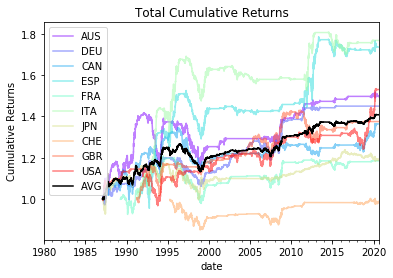

In [15]:
pnl_curve(CH_signals)

Finally, we want to compare the returns generated by this signal to the returns from a long-only signal. The average correlation is -0.02, which is fairly low.

In [16]:
pd.DataFrame(corr_with_long(CH_signals))

,0
country,
AUS,-0.013273
DEU,0.004038
CAN,-0.011369
ESP,0.317875
FRA,0.012115
ITA,0.356781
JPN,-0.601747
CHE,-0.050390
GBR,-0.125557


# Change in GDP

Change in Real GDP is a good indicator on how the economy is doing overall, which can give investors a hint about future bond returns. When growth is higher than average, the economy is doing well, and lots of people are borrowing and spending money. We can assume that generally, a high demand for borrowing would leave to increased interest rates. As the economy heats up, the central bank may also raise interest rates to slow inflation. Additionally, when the economy is doing well, there may be more domestic opportunity, or other places to invest or spend money, which decreases the demand for bonds.

On the other hand, during a recession, the central bank may lower interest rates to stimulate the economy. The demand for long-term bonds also increases, because people want to lock in rates of return. 

Overall, this creates an inverse relationship between real GDP growth and bond returns: when growth is high, bonds drop in price and returns are negative, and when growth is low, bonds rise in price and returns are positive.

In [18]:
RGDP = dl.pull("GDP/Real")
RGDP_QOQ = RGDP.pct_change()
RGDP_QOQ.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,0.005546,0.003093,0.002792,0.004047,0.001579,0.000052,0.000038,0.004400,0.005116,0.006369
2019Q4,0.005209,-0.000187,0.001397,0.004104,-0.001856,-0.002286,-0.018566,0.003379,-0.000001,0.005862
2020Q1,-0.003060,-0.020186,-0.021089,-0.052090,-0.059396,-0.053805,-0.005586,-0.026071,-0.021872,-0.012627
2020Q2,0.000000,-0.100915,0.000000,-0.184840,-0.138151,-0.123579,0.000000,0.000000,0.000000,-0.094947
2020Q3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
global_avg_1Y = RGDP_QOQ.rolling(4).mean().mean(axis=1)
relative_growth = (RGDP_QOQ.sub(global_avg_1Y, axis=0))

standardized_rel_growth = (relative_growth.rolling(28).
                           mean()-relative_growth)/relative_growth.rolling(28).std()

standardized_rel_growth.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,-0.049572,0.039035,0.341381,0.165975,0.460590,0.230537,0.345114,-0.104061,-0.331200,-0.279224
2019Q4,-0.296526,0.595567,0.429977,-0.005488,1.302347,0.914352,2.438509,-0.069151,1.195511,-0.357964
2020Q1,-0.249494,2.739091,2.848431,4.888745,4.907237,4.963611,-0.300591,3.892224,3.962012,2.378498
2020Q2,-4.274271,4.846100,-3.158132,4.875071,4.592448,4.592257,-2.762808,-3.317249,-3.702290,4.944622
2020Q3,-3.304413,-1.600318,-2.718520,-0.856999,-1.196611,-1.413745,-2.468936,-2.806771,-3.056482,-1.557512


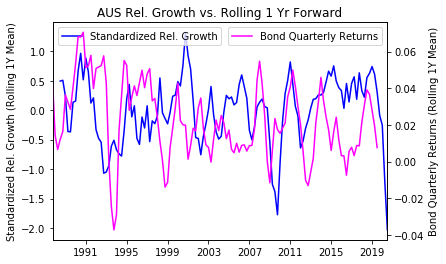

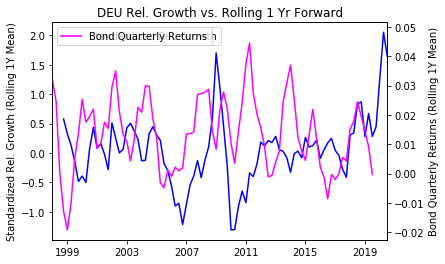

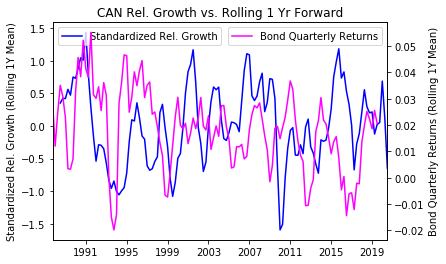

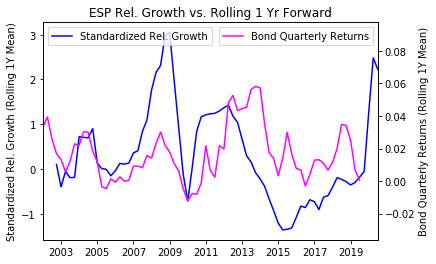

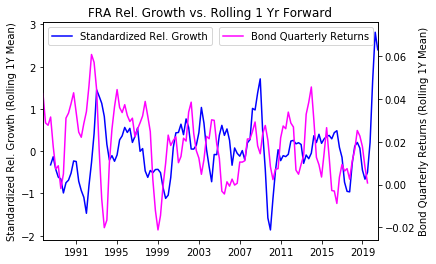

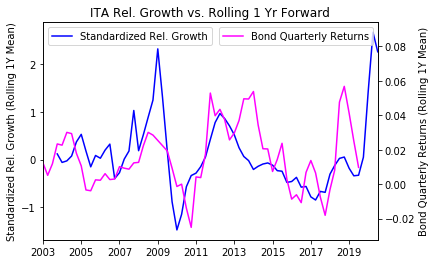

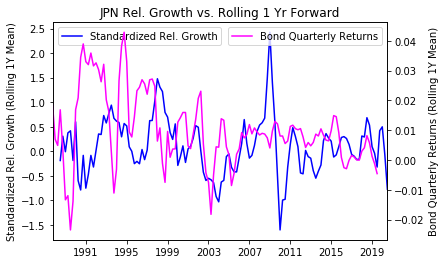

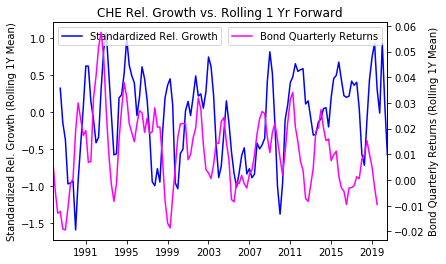

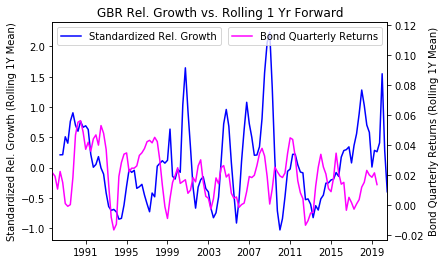

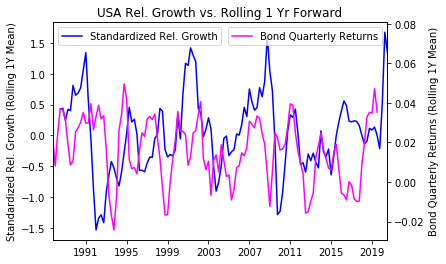

In [20]:
bond_quarterly_returns = bond_return_index.resample('Q').mean().pct_change()
shifted_quarterly_returns = bond_quarterly_returns.shift(-4)

for country in country_codes:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = 'Standardized Rel. Growth'
    ax1.plot(standardized_rel_growth[country].rolling(4).mean().dropna()
             .to_timestamp(), color='blue', label = ax1_label)
    ax1.set_ylabel('Standardized Rel. Growth (Rolling 1Y Mean)')
    ax1.legend(loc=2)
    ax2_label = 'Bond Quarterly Returns'
    ax2.plot(shifted_quarterly_returns[country].to_timestamp()
         .rolling(4).mean(),color='magenta', label = ax2_label)
    ax2.set_ylabel('Bond Quarterly Returns (Rolling 1Y Mean)')
    ax2.legend(loc='best')
    
    plt.xlim(str(standardized_rel_growth[country].dropna().index.min()), 
            str(standardized_rel_growth[country].dropna().index.max()))
    plt.title(country + ' Rel. Growth vs. Rolling 1 Yr Forward')
    plt.show()

In [21]:
GDP_signals = standardized_rel_growth.divide(2).clip(-1,1)
sharpe_ratio(GDP_signals)

country
AUS        0.158943
DEU        0.258927
CAN        0.389954
ESP       -0.045953
FRA        0.501836
ITA       -0.017908
JPN       -0.128224
CHE        0.428760
GBR        0.192466
USA        0.589699
AVERAGE    0.232850
dtype: float64

In [22]:
GDP_signals[np.abs(GDP_signals) < .25] = 0
sharpe_ratio(GDP_signals)

country
AUS        0.183832
DEU        0.305970
CAN        0.383938
ESP       -0.045605
FRA        0.465368
ITA        0.034146
JPN       -0.109692
CHE        0.434716
GBR        0.136556
USA        0.623548
AVERAGE    0.241278
dtype: float64

In [23]:
GDP_signals = GDP_signals.rolling(2).mean()

In [24]:
pd.DataFrame(sharpe_ratio(GDP_signals))

,0
country,
AUS,0.229375
DEU,0.327141
CAN,0.204512
ESP,-0.037411
FRA,0.518990
ITA,0.165461
JPN,0.374739
CHE,0.483760
GBR,0.201448


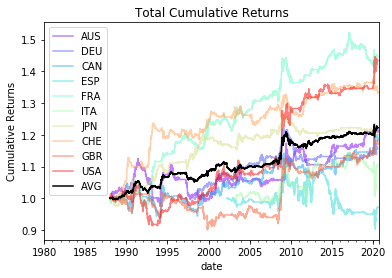

In [25]:
pnl_curve(GDP_signals)

In [26]:
pd.DataFrame(corr_with_long(GDP_signals))

,0
country,
AUS,-0.149158
DEU,0.154670
CAN,-0.006630
ESP,0.426415
FRA,0.095517
ITA,0.413626
JPN,0.077592
CHE,0.000825
GBR,0.094656


# Combining Indicators

**Naive Weighting**

In [728]:
GDP_signals = GDP_signals.resample('M').ffill()
signals = .5*GDP_signals + .5*CH_signals

country
AUS        0.310076
DEU        0.647374
CAN        0.272582
ESP        0.133758
FRA        0.456272
ITA        0.225740
JPN        0.407109
CHE        0.130159
GBR        0.364477
USA        0.471180
AVERAGE    0.341873
dtype: float64

In [737]:
GDP_vol_weight = CH_signals.std()/(GDP_signals.std()+CH_signals.std())
CH_vol_weight = GDP_signals.std()/(GDP_signals.std()+CH_signals.std())

signals = GDP_vol_weight*GDP_signals + CH_vol_weight*CH_signals
sharpe_ratio(signals)

country
AUS        0.308836
DEU        0.612738
CAN        0.270707
ESP        0.139042
FRA        0.481324
ITA        0.221742
JPN        0.448702
CHE        0.151177
GBR        0.353158
USA        0.472163
AVERAGE    0.345959
dtype: float64

**Rolling Sharpe-Weighted Combination by Country**

In [705]:
def rolling_sharpe_ratio(signals, date):
    
    end_date = date - 1
    start_date = date - 13
    
    daily_signals = signals.resample("B").ffill()
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix 
    lagged_returns = bond_daily_returns.shift(-1)

    returns = (lagged_returns * daily_signals).loc['1980-01-01': end_date]
    
    country_SR = pd.Series(float(), index=country_codes)
    
    for country in country_codes:
        country_returns = returns[country].dropna()
        gmean_returns = gmean(1+country_returns)
        overall_return = (gmean_returns)**(261)-1
        overall_risk = country_returns.std()*np.sqrt(261)
        country_SR[country] = overall_return/overall_risk
    
    country_SR['AVERAGE'] = country_SR.mean()
    
    return(country_SR)

CH_sharpe_table = pd.DataFrame(0, index=CH_signals.index, columns=CH_signals.columns)
GDP_sharpe_table = pd.DataFrame(0, index=GDP_signals.index, columns=GDP_signals.columns)

for date in CH_signals.iloc[13:].index:
    CH_sharpe_table.loc[date] = rolling_sharpe_ratio(CH_signals, date)
    
for date in GDP_signals.iloc[13:].index:
    GDP_sharpe_table.loc[date] = rolling_sharpe_ratio(GDP_signals, date)
    


/Users/meganhoward1/.local/share/virtualenvs/Internship2020-nLH2vFU1/lib/python3.6/site-packages/scipy/stats/stats.py:411: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))
/Users/meganhoward1/.local/share/virtualenvs/Internship2020-nLH2vFU1/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/meganhoward1/.local/share/virtualenvs/Internship2020-nLH2vFU1/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [722]:
np.mean(CH_signals==0).mean()

0.14241803278688528

In [706]:
CH_sharpe_table[CH_sharpe_table<0] = 0
GDP_sharpe_table[GDP_sharpe_table<0] = 0

summed = CH_sharpe_table+GDP_sharpe_table
CH_sharpes = CH_sharpe_table/summed
GDP_sharpes = GDP_sharpe_table/summed

In [707]:
GDP_NA = GDP_sharpes.isna()
CH_NA = CH_sharpes.isna()

In [708]:
GDP_sharpes[GDP_NA | CH_NA] = .5
CH_sharpes[GDP_NA | CH_NA] = .5

In [709]:
GDP_weights = GDP_sharpes
CH_weights = CH_sharpes

In [636]:
GDP_NA = GDP_weights.isna()
CH_NA = CH_weights.isna()
GDP_weights[GDP_NA | CH_NA] = .5
CH_weights[GDP_NA | CH_NA] = .5

In [710]:
sharpe_signals = GDP_weights*GDP_signals + CH_weights*CH_signals

In [711]:
sharpe_ratio(sharpe_signals)

country
AUS        0.181808
DEU        0.583916
CAN        0.209595
ESP        0.232006
FRA        0.497553
ITA        0.197204
JPN        0.380512
CHE        0.232857
GBR        0.387211
USA        0.369345
AVERAGE    0.327201
dtype: float64

**Amplify Signals that Agree in Direction**

In [738]:
signals[GDP_signals*CH_signals > 0] = (signals
                                       *1.5).clip(-1,1)
sharpe_ratio(signals)

country
AUS        0.299387
DEU        0.668964
CAN        0.273799
ESP        0.152246
FRA        0.499666
ITA        0.256845
JPN        0.451044
CHE        0.158880
GBR        0.323241
USA        0.502084
AVERAGE    0.358616
dtype: float64

**Dampen Signals that Disagree in Direction**

In [739]:
signals[GDP_signals*CH_signals < 0] = (signals
                                       /1.5).clip(-1,1)
sharpe_ratio(signals)

country
AUS        0.319746
DEU        0.701122
CAN        0.282452
ESP        0.152551
FRA        0.514186
ITA        0.258845
JPN        0.442992
CHE        0.168659
GBR        0.328197
USA        0.493457
AVERAGE    0.366221
dtype: float64

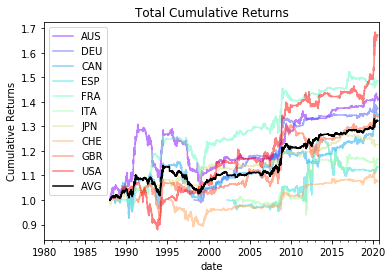

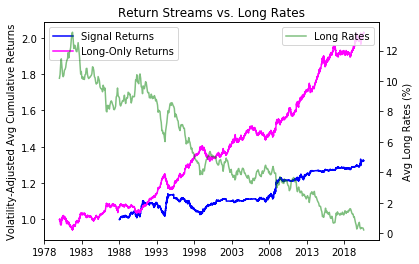

In [725]:
pnl_curve(signals)
pnl_curve_with_long(signals)

In [740]:
pd.DataFrame(corr_with_long(signals))

,0
country,
AUS,-0.126819
DEU,0.383691
CAN,-0.020532
ESP,0.350339
FRA,0.103222
ITA,0.354399
JPN,-0.239028
CHE,-0.017842
GBR,-0.110247


In [1260]:
long_signals = pd.DataFrame(1, index=signals.index,
                                columns=signals.columns)
lol = pd.concat([sharpe_ratio(signals),sharpe_ratio(long_signals),corr_with_long(signals)],
          axis=1)

lol.columns = ['Signal Returns SR', 'Long Only Returns SR', 'Correlation Between Returns']
lol

,Signal Returns SR,Long Only Returns SR,Correlation Between Returns
country,,,
AUS,0.359937,0.792197,-0.115706
DEU,0.744215,0.450721,0.389833
CAN,0.271651,0.672322,-0.007218
ESP,0.340508,0.931742,0.254654
FRA,0.540239,0.765722,0.124716
ITA,0.251562,0.824204,0.284153
JPN,0.447222,0.189995,-0.247297
CHE,0.300489,0.158318,0.075798
GBR,0.362759,0.690960,-0.101465


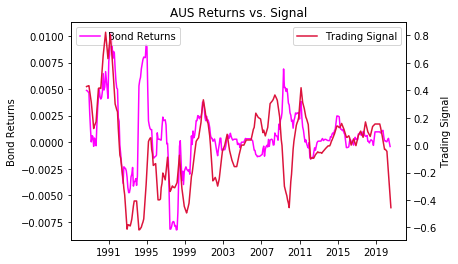

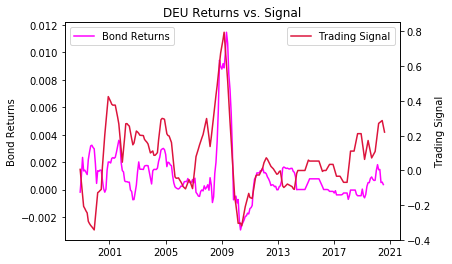

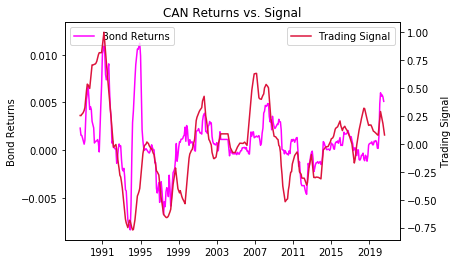

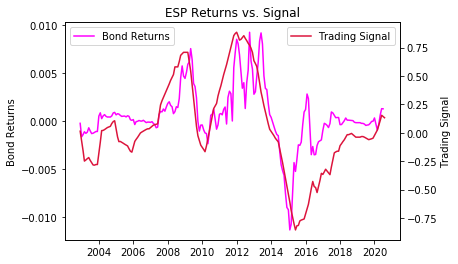

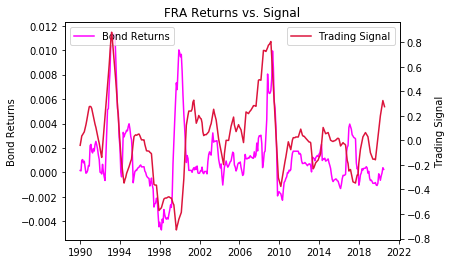

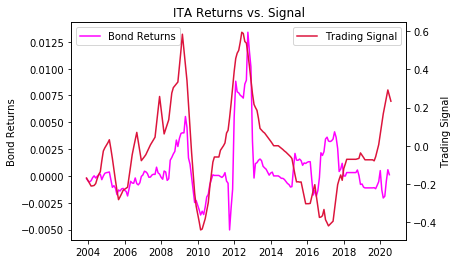

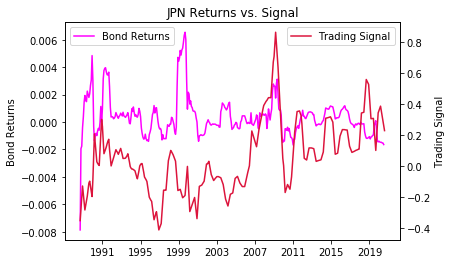

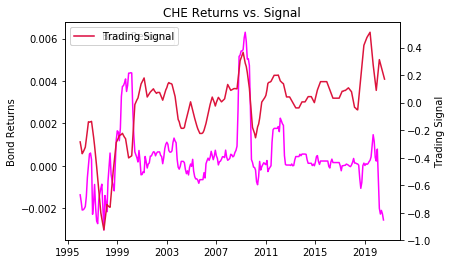

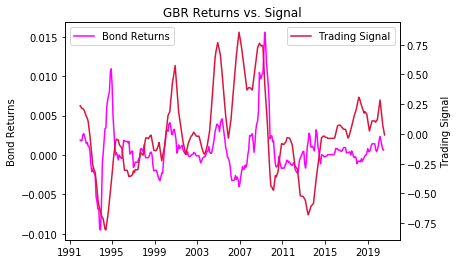

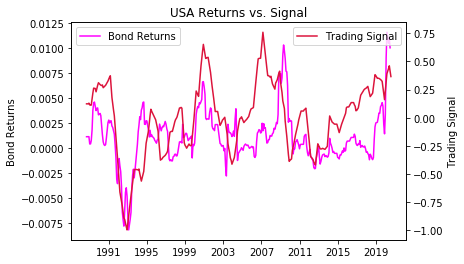

In [223]:
bond_monthly_returns = bond_return_index.resample('M').mean().pct_change() - rf_rate_matrix_monthly
lagged_returns = bond_monthly_returns.shift(-1)
    
sig_returns = (lagged_returns * signals)
cum_sig_returns = (1+sig_returns).cumprod()
sig_pct = (cum_sig_returns-1)*100

for country in country_codes:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(sig_returns[country].rolling(12).mean().dropna()
             .to_timestamp(), color='magenta', label = 'Bond Returns')
    ax1.set_ylabel('Bond Returns')
    ax1.legend(loc=2)
    ax2.plot(signals[country].to_timestamp().rolling(12).mean()
         ,color='crimson', label = 'Trading Signal')
    ax2.set_ylabel('Trading Signal')
    ax2.legend(loc='best')
    plt.title(country + " Returns vs. Signal")

In [371]:
CPI = dl.pull('EquityPr')
CPI.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,120.459,113.036,116.807,110.470,106.569,110.026,103.943,98.559,120.588,119.999
2020-05,119.996,112.912,116.634,110.477,106.911,110.047,104.148,98.539,120.450,119.927
2020-06,NaN,113.277,117.240,110.483,106.860,109.989,104.250,98.544,120.939,120.209
2020-07,NaN,NaN,NaN,NaN,NaN,109.861,NaN,98.762,NaN,NaN
2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [373]:
inf_exp = CPI.pct_change().rolling(12).mean()

In [374]:
global_avg_1Y = inf_exp.rolling(12).mean().mean(axis=1)
relative_inf= (inf_exp.sub(global_avg_1Y, axis=0))

standardized_inf = (relative_inf - relative_inf.rolling(28).mean())/relative_inf.rolling(28).std()



In [375]:
cpi_sig = standardized_inf.divide(2).clip(-1,1)

In [377]:
sharpe_ratio(-1*cpi_sig)

country
AUS        0.198986
DEU       -0.132874
CAN       -0.276176
ESP        0.183780
FRA        0.080718
ITA        0.428112
JPN       -0.219002
CHE       -0.209393
GBR        0.078967
USA       -0.084467
AVERAGE    0.004865
dtype: float64